In [2]:
import random
import numpy as np
from numpy.linalg import norm
import pickle
from tqdm import tqdm, tqdm_notebook
import os
import time
import tensorflow as tf
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

In [3]:
model = ResNet50(weights='imagenet', include_top=False,
                 input_shape=(224, 224, 3))
def extract_features(img_path, model):
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(
        input_shape[0], input_shape[1]))
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

94773248/94765736 [==============================] - ETA: 12 - ETA: 2: - ETA: 1: - ETA: 1: - ETA: 46s - ETA: 26 - ETA: 14 - ETA: 7 - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 3s 0us/step


In [3]:
#features = extract_features('./ump_data/sample_images/cat.jpg', model)
#print(len(features))

In [33]:
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

# path to the datasets
root_dir = './test'
filenames = sorted(get_file_list(root_dir))

feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))


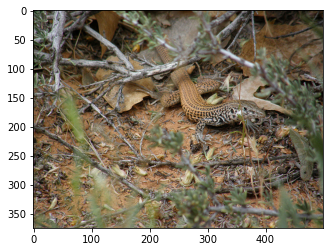

In [34]:
#Similarity Search
from sklearn.neighbors import NearestNeighbors
neighbors = NearestNeighbors(n_neighbors=5, algorithm='brute',
metric='euclidean').fit(feature_list)
distances, indices = neighbors.kneighbors([feature_list[0]])
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Show the plots as a cell within the Jupyter Notebooks
%matplotlib inline       
plt.imshow(mpimg.imread(filenames[0]))

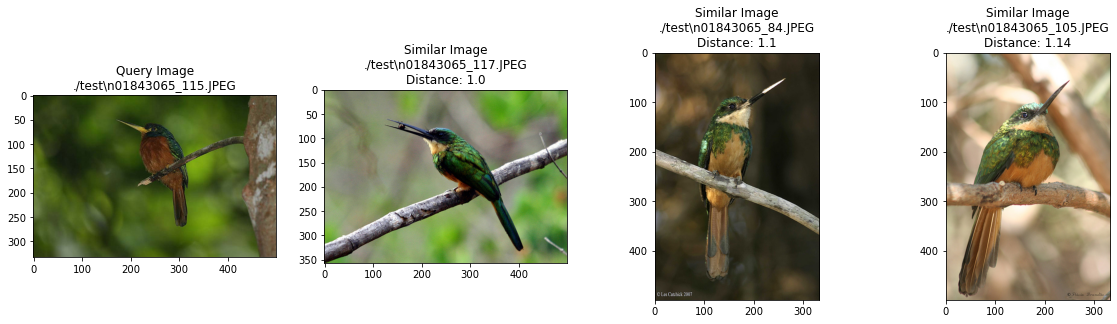

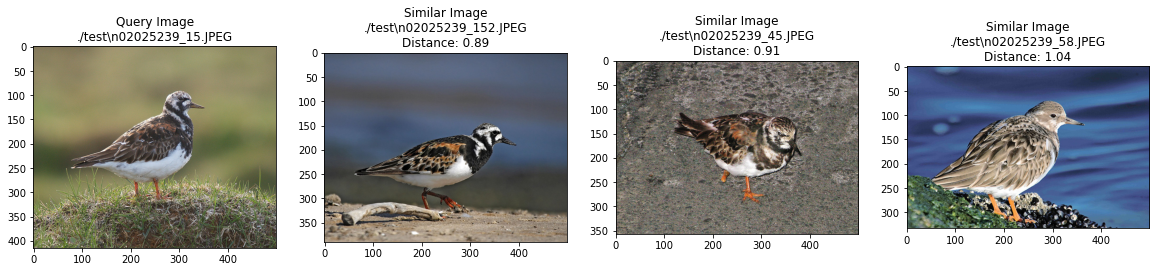

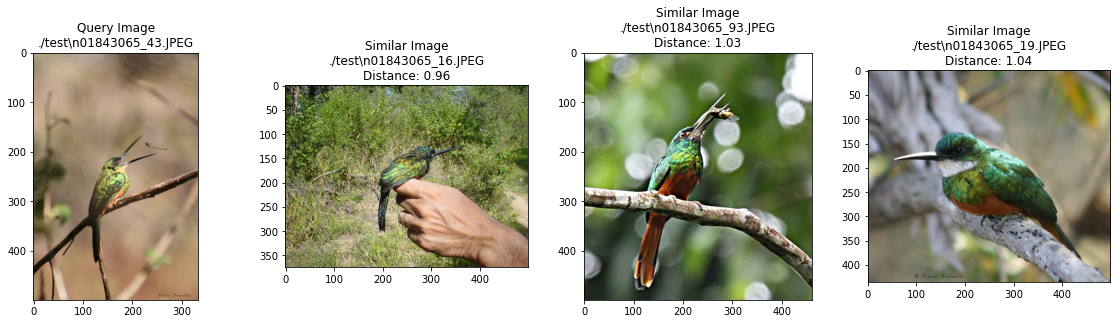

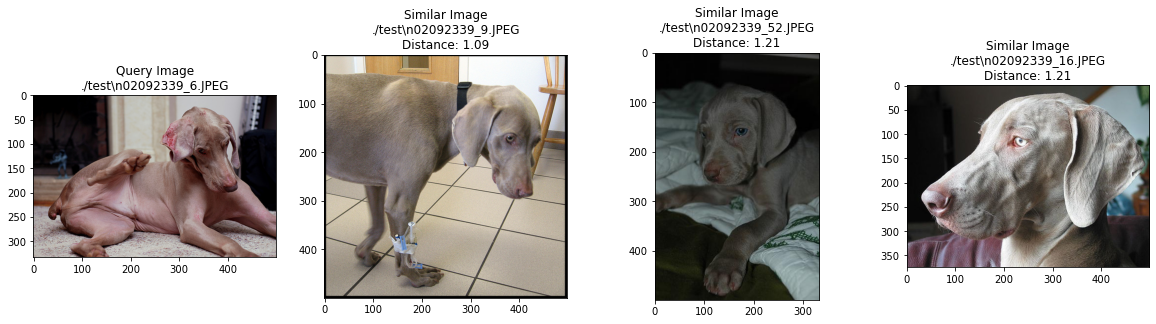

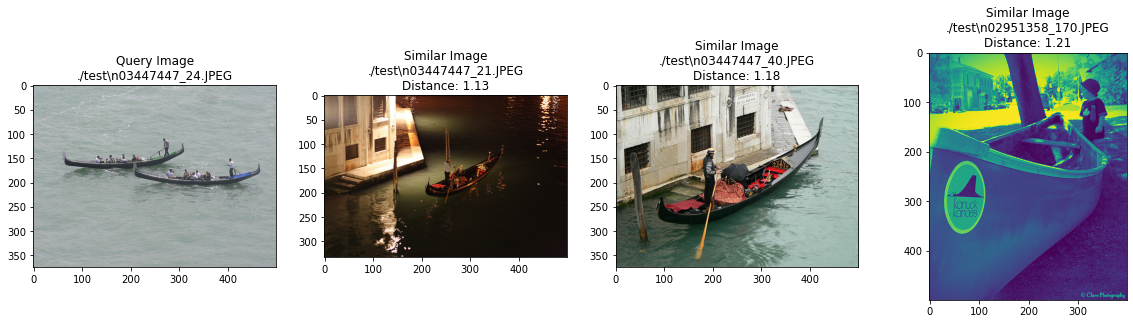

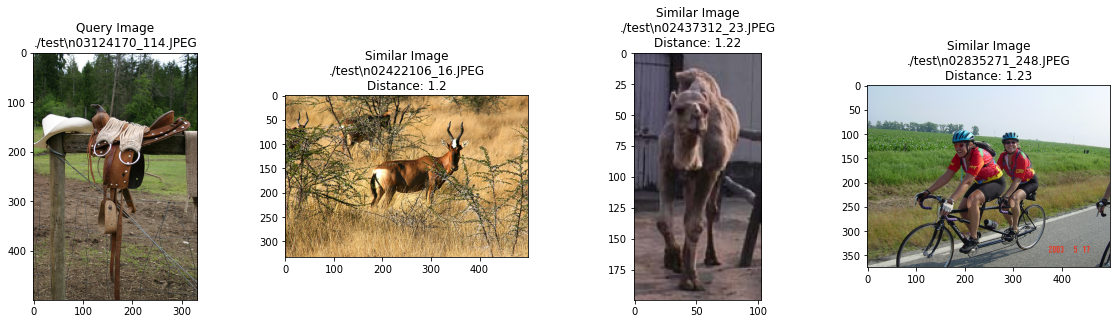

In [35]:
# Helper function to get the classname
def classname(str):
    return str.split('/')[-2]

# Helper function to get the classname and filename
def classname_filename(str):
    return str.split('/')[-2] + '/' + str.split('/')[-1]
# Helper functions to plot the nearest images given a query image
def plot_images(filenames, distances):
    images = []
    for filename in filenames:
        images.append(mpimg.imread(filename))
    plt.figure(figsize=(20, 10))
    columns = 4
    for i, image in enumerate(images):
        ax = plt.subplot(len(images) / columns + 1, columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + classname_filename(filenames[i]))
        else:
            ax.set_title("Similar Image\n" + classname_filename(filenames[i]) +
                         "\nDistance: " +
                         str(float("{0:.2f}".format(distances[i]))))
        plt.imshow(image)
        # To save the plot in a high definition format i.e. PDF, uncomment the following line:
        #plt.savefig('results/' + str(random.randint(0,10000))+'.pdf', format='pdf', dpi=1000)
        
num_images = 300
for i in range(6):
    random_image_index = random.randint(0,num_images)
    distances, indices = neighbors.kneighbors([feature_list[random_image_index]])
    # don't take the first closest image as it will be the same image
    similar_image_paths = [filenames[random_image_index]] + [filenames[indices[0][i]] for i in range(1,4)]
    plot_images(similar_image_paths, distances[0])



Found 300 images belonging to 30 classes.
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.010s...
[t-SNE] Computed neighbors for 300 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.331343
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.031631
[t-SNE] KL divergence after 1000 iterations: 0.743423


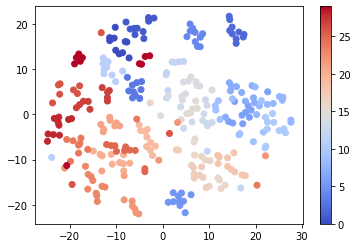

In [32]:
#Visualizing Image Clusters with t-SNE

# Perform PCA over the features
num_feature_dimensions=100      # Set the number of features
pca = PCA(n_components = num_feature_dimensions)
pca.fit(feature_list)
feature_list_compressed = pca.transform(feature_list)

#create class_idsv from datagen.flow_from_directory

batch_size = 64
datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

generator = datagen.flow_from_directory(root_dir,
                                        target_size=(224, 224),
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=False)
class_ids = generator.classes

# For speed and clarity, we'll analyze about first half of the dataset.
selected_features = feature_list_compressed[:]
selected_class_ids = class_ids[:]
selected_filenames = filenames[:]

tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean').fit_transform(selected_features)

# Plot a scatter plot from the generated t-SNE results
colormap = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:,0],tsne_results[:,1], c =selected_class_ids, cmap=colormap)
plt.colorbar(scatter_plot)
plt.show()

!
!
!
Found 300 images belonging to 30 classes.
!
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 300 samples in 0.005s...
[t-SNE] Computed neighbors for 300 samples in 0.022s...
[t-SNE] Computed conditional probabilities for sample 300 / 300
[t-SNE] Mean sigma: 0.332072
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.046036
[t-SNE] KL divergence after 1000 iterations: 0.750740


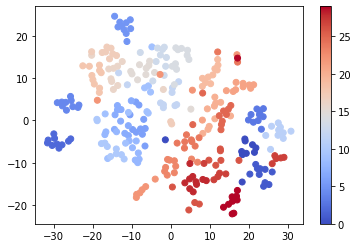

In [40]:
#Visualizing Image Clusters with t-SNE

# Perform PCA over the features
num_feature_dimensions=100      # Set the number of features
pca = PCA(n_components = num_feature_dimensions)
print("!")
pca.fit(feature_list)
print("!")
feature_list_compressed = pca.transform(feature_list)

#create class_idsv from datagen.flow_from_directory

print("!")
batch_size = 64
datagen = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)
root_dir1 = './image'
generator = datagen.flow_from_directory(root_dir1,
                                        target_size=(224, 224),
                                        batch_size=batch_size,
                                        class_mode='categorical',
                                        shuffle=False)
class_ids = generator.classes

print("!")
# For speed and clarity, we'll analyze about first half of the dataset.
selected_features = feature_list_compressed[:]
selected_class_ids = class_ids[:]
selected_filenames = filenames[:]

tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean').fit_transform(selected_features)

# Plot a scatter plot from the generated t-SNE results
colormap = plt.cm.get_cmap('coolwarm')
scatter_plot = plt.scatter(tsne_results[:,0],tsne_results[:,1], c =selected_class_ids, cmap=colormap)
plt.colorbar(scatter_plot)
plt.show()